In [17]:
# === Cell 1: Imports + Config ===
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Any

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn Common
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.base import clone

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Imbalanced Learn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# -------------------------
# Config
# -------------------------
DATA_DIR = Path("datasets")
MODULE = "BBB"
PRESENTATIONS = ["2013B", "2013J"]

CUTOFFS = [3, 5, 7, 10, 14, 21, 30, 45, 60, 90, 120, 150, 180]

WINDOW_DAYS = 14
HALF_WINDOW = 7
HORIZON = 7
VAR_THRESH = 0.0

# File này sẽ lưu model TỐT NHẤT trong 4 model
MODEL_PATH = "best_churn_model.pkl" 

logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(levelname)s - %(message)s")

In [18]:
# === Cell 2: Load raw OULAD ===
def load_raw(data_dir: Path) -> Dict[str, pd.DataFrame]:
    return {
        "student_info": pd.read_csv(data_dir / "studentInfo.csv"),
        "student_reg": pd.read_csv(data_dir / "studentRegistration.csv"),
        "student_vle": pd.read_csv(data_dir / "studentVle.csv"),
    }


def prepare_students(raw: Dict[str, pd.DataFrame], module: str, presentations: List[str]):
    reg_mod = raw["student_reg"][
        (raw["student_reg"]["code_module"] == module)
        & (raw["student_reg"]["code_presentation"].isin(presentations))
    ].copy()

    reg_lookup = reg_mod[["id_student", "date_registration"]].drop_duplicates()

    students = raw["student_info"][
        (raw["student_info"]["code_module"] == module)
        & (raw["student_info"]["code_presentation"].isin(presentations))
        & (raw["student_info"]["id_student"].isin(reg_lookup["id_student"]))
    ].copy()

    vle_mod = raw["student_vle"][
        (raw["student_vle"]["code_module"] == module)
        & (raw["student_vle"]["code_presentation"].isin(presentations))
    ].merge(reg_lookup, on="id_student", how="inner")

    vle_mod["days_since_reg"] = vle_mod["date"] - vle_mod["date_registration"]
    vle_mod = vle_mod[vle_mod["days_since_reg"].notna()].copy()
    vle_mod = vle_mod[vle_mod["days_since_reg"] >= 0].copy()

    logging.info("So hoc vien hop le: %d", students["id_student"].nunique())
    logging.info("So ban ghi VLE: %d", len(vle_mod))
    return students, vle_mod



In [19]:
# === Cell 3: Helpers ===
def compute_inactivity_streak(days_list: List[int], start_day: int, end_day: int) -> int:
    if not days_list:
        return end_day - start_day + 1
    active = set(days_list)
    streak, d = 0, end_day
    while d >= start_day and d not in active:
        streak += 1
        d -= 1
    return streak


def build_has_future_activity(vle_mod: pd.DataFrame, cutoff: int, horizon: int = 7) -> pd.DataFrame:
    """
    Trả về has_future=1 nếu có ít nhất 1 activity trong (cutoff+1 .. cutoff+horizon)
    Những student không xuất hiện -> has_future=0 (fill later)
    """
    future = vle_mod[(vle_mod["days_since_reg"] > cutoff) & (vle_mod["days_since_reg"] <= cutoff + horizon)]
    has_future = future.groupby("id_student").size().gt(0).astype(int).reset_index(name="has_future")
    return has_future



In [20]:
# === Cell 4: Build features (last 14 days) + label next 7 days ===
def build_features_short_term(
    students: pd.DataFrame,
    vle_mod: pd.DataFrame,
    cutoffs: List[int],
    window_days: int = WINDOW_DAYS,
    half_window: int = HALF_WINDOW,
    horizon: int = HORIZON,
) -> Tuple[pd.DataFrame, List[str]]:

    student_ids = students["id_student"].unique()
    augmented = []

    for cutoff in cutoffs:
        w_start = max(0, cutoff - (window_days - 1))
        w_end = cutoff

        base = pd.DataFrame({"id_student": student_ids})
        base["days_elapsed_since_reg"] = cutoff

        # Label: y=1 if NO future activity in horizon
        label_df = build_has_future_activity(vle_mod, cutoff, horizon=horizon)
        merged = base.merge(label_df, on="id_student", how="left")
        merged["has_future"] = merged["has_future"].fillna(0).astype(int)
        merged["y_short"] = (merged["has_future"] == 0).astype(int)

        # Logs for features
        vle_cum = vle_mod[vle_mod["days_since_reg"] <= cutoff].copy()
        vle_win = vle_cum[vle_cum["days_since_reg"] >= w_start].copy()

        cum_agg = (
            vle_cum.groupby("id_student")
            .agg(
                total_clicks=("sum_click", "sum"),
                active_days_total=("days_since_reg", "nunique"),
                last_active=("days_since_reg", "max"),
            )
            .reset_index()
        )
        cum_agg["clicks_per_day_total"] = cum_agg["total_clicks"] / max(cutoff, 1)
        cum_agg["active_ratio_total"] = cum_agg["active_days_total"] / max(cutoff, 1)
        cum_agg["days_since_last_active"] = cutoff - cum_agg["last_active"]
        cum_agg["avg_clicks_per_active_day_total"] = (
            cum_agg["total_clicks"] / cum_agg["active_days_total"].replace(0, np.nan)
        ).fillna(0)

        win_agg = (
            vle_win.groupby("id_student")
            .agg(
                clicks_last_14_days=("sum_click", "sum"),
                active_days_14=("days_since_reg", "nunique")
            )
            .reset_index()
        )
        win_agg["clicks_per_day_14"] = win_agg["clicks_last_14_days"] / window_days
        win_agg["active_ratio_14"] = win_agg["active_days_14"] / window_days

        first_end = min(w_end, w_start + (half_window - 1))
        second_start = min(w_end, first_end + 1)

        clicks_0_7 = (
            vle_win[(vle_win["days_since_reg"] >= w_start) & (vle_win["days_since_reg"] <= first_end)]
            .groupby("id_student")["sum_click"].sum().reset_index(name="clicks_0_7")
        )
        clicks_8_14 = (
            vle_win[(vle_win["days_since_reg"] >= second_start) & (vle_win["days_since_reg"] <= w_end)]
            .groupby("id_student")["sum_click"].sum().reset_index(name="clicks_8_14")
        )

        clicks_last_7 = (
            vle_cum[vle_cum["days_since_reg"] > (cutoff - 7)]
            .groupby("id_student")["sum_click"].sum().reset_index(name="clicks_last_7_days")
        )

        days_list = (
            vle_win.groupby("id_student")["days_since_reg"]
            .apply(lambda x: sorted(x.unique()))
            .reset_index()
            .rename(columns={"days_since_reg": "active_days_list"})
        )
        days_list["inactivity_streak_14"] = days_list["active_days_list"].apply(
            lambda lst: compute_inactivity_streak(lst, w_start, w_end)
        )
        streak = days_list[["id_student", "inactivity_streak_14"]]

        merged = merged.merge(cum_agg, on="id_student", how="left")
        merged = merged.merge(win_agg, on="id_student", how="left")
        merged = merged.merge(clicks_0_7, on="id_student", how="left")
        merged = merged.merge(clicks_8_14, on="id_student", how="left")
        merged = merged.merge(clicks_last_7, on="id_student", how="left")
        merged = merged.merge(streak, on="id_student", how="left")

        fill0 = [
            "total_clicks","active_days_total","last_active",
            "clicks_per_day_total","active_ratio_total","days_since_last_active","avg_clicks_per_active_day_total",
            "clicks_last_14_days","active_days_14","clicks_per_day_14","active_ratio_14",
            "clicks_last_7_days","clicks_0_7","clicks_8_14","inactivity_streak_14"
        ]
        for col in fill0:
            merged[col] = merged[col].fillna(0)

        merged["trend_click_14"] = merged["clicks_8_14"] - merged["clicks_0_7"]
        merged["ratio_click_14"] = (merged["clicks_8_14"] + 1) / (merged["clicks_0_7"] + 1)

        augmented.append(merged)

    final_df = pd.concat(augmented, ignore_index=True)

    feature_cols = [
        "days_elapsed_since_reg",
        "clicks_per_day_total",
        "active_ratio_total",
        "avg_clicks_per_active_day_total",
        "days_since_last_active",
        "clicks_last_14_days",
        "active_days_14",
        "clicks_per_day_14",
        "active_ratio_14",
        "clicks_last_7_days",
        "clicks_0_7",
        "clicks_8_14",
        "trend_click_14",
        "ratio_click_14",
        "inactivity_streak_14",
    ]
    return final_df, feature_cols



In [21]:
# === Cell 5: Pipelines Factory (Updated for Multi-Models) ===

# Danh sách các Model cần thử nghiệm
MODELS = {
    "LogisticRegression": LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ),
    # "GradientBoosting": GradientBoostingClassifier(
    #     learning_rate=0.05,
    #     max_depth=3,
    #     min_samples_leaf=40,
    #     min_samples_split=20,
    #     n_estimators=150,
    #     random_state=42
    # ),
    # "MLP": MLPClassifier(
    #     hidden_layer_sizes=(128,),
    #     max_iter=1200,
    #     early_stopping=True,
    #     random_state=42
    # )
}

def make_eval_pipe(clf):
    """Pipeline dùng để Evaluate (có SMOTE)"""
    return ImbPipeline([
        ("variance_threshold", VarianceThreshold(VAR_THRESH)),
        ("smote", SMOTE(random_state=42)), # Oversampling cho tập Train trong CV
        ("power_transformer", PowerTransformer()), # Scale dữ liệu (quan trọng cho MLP/Logistic)
        ("classifier", clf)
    ])

def make_prod_pipe(clf):
    """Pipeline dùng cho Production (Không SMOTE, dùng class_weight của model)"""
    return SkPipeline([
        ("variance_threshold", VarianceThreshold(VAR_THRESH)),
        ("power_transformer", PowerTransformer()),
        ("classifier", clf)
    ])

def make_prod_pipe_rf():
    return SkPipeline([
        ("variance_threshold", VarianceThreshold(VAR_THRESH)),
        
        # Lưu ý: Random Forest KHÔNG CẦN PowerTransformer (chuẩn hóa)
        # Bỏ đi sẽ giúp code chạy nhanh hơn mà không giảm độ chính xác.
        
        ("classifier", RandomForestClassifier(
            # --- Các tham số cấu trúc cây (bạn có thể chỉnh) ---
            n_estimators=300,
            max_depth=12,
            min_samples_split=10,
            min_samples_leaf=5,
            n_jobs=-1,
            random_state=42,

            # --- TRỌNG SỐ (Cái bạn quan tâm nhất) ---
            # Random Forest hỗ trợ y hệt Logistic Regression.
            # Bạn có thể ép nó bắt lỗi user bỏ học (1) gấp 3 lần user thường (0).
            class_weight={0: 1, 1: 3} 
        )),
    ])

In [22]:
# === Cell 6: Train/Eval 4 Models & Select Best ===
# 1. Load & Prep Data
raw = load_raw(DATA_DIR)
students, vle_mod = prepare_students(raw, MODULE, PRESENTATIONS)

final_df, feature_cols = build_features_short_term(
    students, vle_mod, CUTOFFS,
    window_days=WINDOW_DAYS, half_window=HALF_WINDOW, horizon=HORIZON
)

X = final_df[feature_cols].fillna(0)
y = final_df["y_short"].astype(int)
groups = final_df["id_student"]

logging.info("Train samples: %d", len(final_df))
logging.info("Positive rate (Churn): %.2f%%", 100 * y.mean())

# 2. Run Cross-Validation for ALL Models
gkf = GroupKFold(n_splits=5)
results_summary = []

best_score = -1.0
best_model_name = None
best_clf_params = None

print("\n" + "="*50)
print("🚀 BẮT ĐẦU SO SÁNH 4 MODELS (GroupKFold)")
print("="*50)

for name, clf_instance in MODELS.items():
    print(f"\nTraining {name}...")
    fold_metrics = []
    
    # Clone để đảm bảo mỗi vòng lặp là một instance sạch
    clf_base = clone(clf_instance)

    for tr_idx, te_idx in gkf.split(X, y, groups):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        # Dùng eval pipeline (có SMOTE)
        pipe = make_eval_pipe(clone(clf_base))
        pipe.fit(X_tr, y_tr)

        y_pred = pipe.predict(X_te)
        # Một số model cần xử lý predict_proba cẩn thận
        try:
            y_proba = pipe.predict_proba(X_te)[:, 1]
        except AttributeError:
            y_proba = y_pred # Fallback nếu model ko hỗ trợ proba (ít gặp)

        tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
        
        fold_metrics.append({
            "auc": roc_auc_score(y_te, y_proba),
            "f1": f1_score(y_te, y_pred),
            "recall": recall_score(y_te, y_pred),
            "accuracy": accuracy_score(y_te, y_pred)
        })

    # Tổng hợp chỉ số trung bình
    metrics_df = pd.DataFrame(fold_metrics)
    mean_auc = metrics_df["auc"].mean()
    mean_f1 = metrics_df["f1"].mean()
    
    print(f"   -> Mean AUC: {mean_auc:.4f} | Mean F1: {mean_f1:.4f}")
    
    results_summary.append({
        "Model": name,
        "Mean_AUC": mean_auc,
        "Mean_F1": mean_f1,
        "Mean_Recall": metrics_df["recall"].mean()
    })

    # Tìm ra model tốt nhất dựa trên AUC
    if mean_auc > best_score:
        best_score = mean_auc
        best_model_name = name
        best_clf_params = clf_base

# 3. Show Leaderboard
print("\n" + "="*30)
print("🏆 KẾT QUẢ XẾP HẠNG")
print("="*30)
leaderboard = pd.DataFrame(results_summary).sort_values(by="Mean_AUC", ascending=False)
display(leaderboard)

print(f"\n✅ Model chiến thắng: {best_model_name} (AUC={best_score:.4f})")

# # 4. Train Full & Save Best Model
# print(f"Đang train lại {best_model_name} trên toàn bộ dữ liệu...")
# final_prod_pipe = make_prod_pipe(best_clf_params)
# final_prod_pipe.fit(X, y)

# joblib.dump({
#     "pipeline": final_prod_pipe, 
#     "feature_cols": feature_cols,
#     "model_name": best_model_name
# }, MODEL_PATH)

# print(f"💾 Đã lưu model tốt nhất vào: {MODEL_PATH}")

# -------------------------------------------------------------
# 4. Train Full & Save SPECIFIC Model (RandomForest) - ĐÃ SỬA
# -------------------------------------------------------------
TARGET_MODEL = "RandomForest"  # <--- Bạn chỉ định tên model muốn lưu ở đây

print(f"\n⚠️ Đang train lại model được chỉ định: {TARGET_MODEL}...")

# Lấy tham số gốc của RandomForest từ biến toàn cục MODELS
target_clf_params = MODELS[TARGET_MODEL] 

# Tạo pipeline production (không SMOTE) và fit lại
final_prod_pipe = make_prod_pipe_rf()
final_prod_pipe.fit(X, y)

joblib.dump({
    "pipeline": final_prod_pipe, 
    "feature_cols": feature_cols,
    "model_name": TARGET_MODEL
}, MODEL_PATH)

print(f"💾 Đã lưu model {TARGET_MODEL} vào: {MODEL_PATH}")

[2025-12-30 18:03:41,566] INFO - So hoc vien hop le: 3960
[2025-12-30 18:03:41,567] INFO - So ban ghi VLE: 864034
[2025-12-30 18:03:43,452] INFO - Train samples: 51480
[2025-12-30 18:03:43,453] INFO - Positive rate (Churn): 72.04%



🚀 BẮT ĐẦU SO SÁNH 4 MODELS (GroupKFold)

Training LogisticRegression...


/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and w

   -> Mean AUC: 0.8730 | Mean F1: 0.9120

Training RandomForest...
   -> Mean AUC: 0.8992 | Mean F1: 0.9109

🏆 KẾT QUẢ XẾP HẠNG


,Model,Mean_AUC,Mean_F1,Mean_Recall
1,RandomForest,0.899245,0.910917,0.900042
0,LogisticRegression,0.872960,0.912033,0.904734



✅ Model chiến thắng: RandomForest (AUC=0.8992)

⚠️ Đang train lại model được chỉ định: RandomForest...
💾 Đã lưu model RandomForest vào: best_churn_model.pkl


🤖 Đang sử dụng model: RandomForest

--- Dự đoán NGẮN HẠN (vắng >7 ngày tới) ---
Student ID: 61
Probability (Churn): 53.57%
Risk Level: MEDIUM (Cảnh báo)
Kết luận: ⚠️ NGUY CƠ CAO


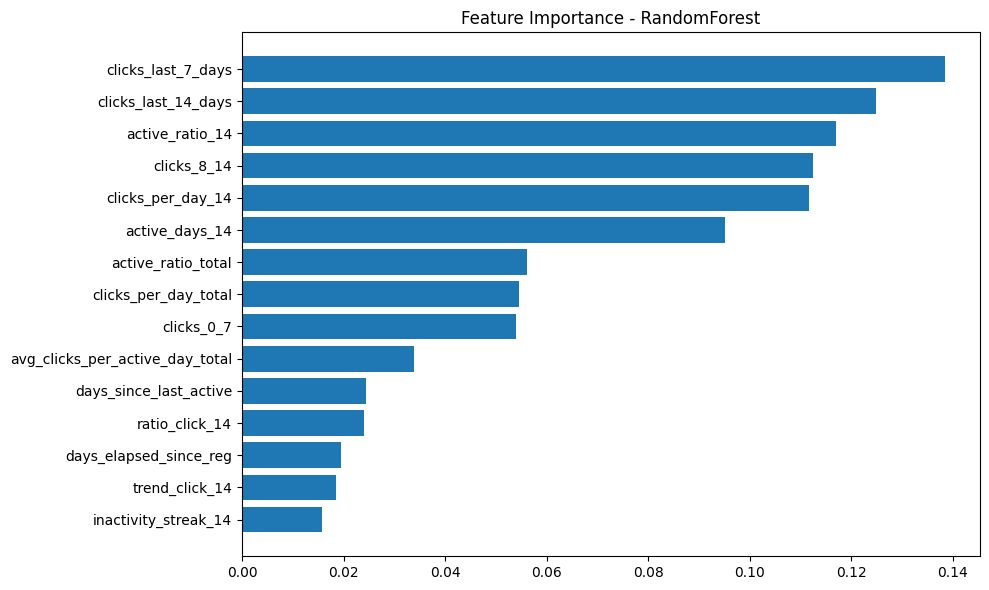

In [23]:
# === Cell 7: Inference (Dùng Best Model để test case cũ) ===
bundle = joblib.load(MODEL_PATH)
loaded_pipe = bundle["pipeline"]
feature_cols = bundle["feature_cols"]
model_name = bundle.get("model_name", "Unknown")

print(f"🤖 Đang sử dụng model: {model_name}")

# Dữ liệu test (Case khó ở trên)
student_data = {
    "student_id": "61",
    "days_elapsed_since_reg": 31,

    "clicks_per_day_total": 0.06,
    "active_ratio_total": 0.06,
    "avg_clicks_per_active_day_total": 0.2,

    "days_since_last_active": 8,           
    "clicks_last_14_days": 1,              
    "active_days_14": 1,
    "clicks_per_day_14": 1/14,
    "active_ratio_14": 1/14,

    "clicks_last_7_days": 0,               
    "clicks_0_7": 0,
    "clicks_8_14": 1,

    "trend_click_14": 1,
    "ratio_click_14": 2.0,

    "inactivity_streak_14": 8              
}

input_df = pd.DataFrame([student_data])[feature_cols].fillna(0)
proba_vang = loaded_pipe.predict_proba(input_df)[0, 1]
pred = loaded_pipe.predict(input_df)[0]

def risk_level(p: float) -> str:
    # Điều chỉnh ngưỡng dựa trên model
    if p >= 0.65: return "HIGH (Báo động)"
    if p >= 0.40: return "MEDIUM (Cảnh báo)"
    return "LOW (An toàn)"

print(f"\n--- Dự đoán NGẮN HẠN (vắng >7 ngày tới) ---")
print(f"Student ID: {student_data['student_id']}")
print(f"Probability (Churn): {proba_vang:.2%}")
print(f"Risk Level: {risk_level(proba_vang)}")
print(f"Kết luận: {'⚠️ NGUY CƠ CAO' if pred==1 else '✅ BÌNH THƯỜNG'}")

# Vẽ Feature Importance nếu model hỗ trợ
clf = loaded_pipe.named_steps["classifier"]
if hasattr(clf, "feature_importances_"):
    # Cho Tree-based models (RF, GBM)
    importances = clf.feature_importances_
    title = f"Feature Importance - {model_name}"
elif hasattr(clf, "coef_"):
    # Cho Linear models (Logistic)
    importances = np.abs(clf.coef_.ravel())
    title = f"Feature Importance (abs coef) - {model_name}"
else:
    importances = None
    print(f"Model {model_name} không hỗ trợ trích xuất Feature Importance trực tiếp.")

if importances is not None:
    imp_series = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    plt.barh(imp_series.head(15).index[::-1], imp_series.head(15).values[::-1])
    plt.title(title)
    plt.tight_layout()
    plt.show()